In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
sns.set()

plt.rc('font', size=30)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
plt.rc('figure', titlesize=30)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet
import cvxpy as cvx
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
returns = pd.read_csv('work/data/returns.csv')
returns = returns.fillna(0)
returns['date'] = returns['date'].astype(np.datetime64)
returns = returns.set_index('date')

train_size = 1500

returns_train = returns[:train_size]
returns_test = returns[train_size:]

In [4]:
np.seterr(all='raise', under='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [42]:
A = np.arange(9).reshape(3, 3)
A.sum(1)

array([ 3, 12, 21])

In [62]:
np.exp(-100)
np.exp(-700)
np.exp(700)

1.0142320547350045e+304

In [80]:
float(1e-6)

1e-06

In [9]:
from mppca import MPPCA

mean = returns_train[returns_train.columns].mean()
top_returns = returns_train[mean.sort_values(ascending=False)[:25].index]

mppca = MPPCA(5, 4)
mppca.fit(top_returns.to_numpy())
mppca_top_returns = mppca.transform(top_returns.to_numpy())

np.mean(mppca_top_returns - top_returns.to_numpy()**2)

0.0010182794514575707

In [109]:
np.seterr(all='ignore')

{'divide': 'raise', 'over': 'raise', 'under': 'ignore', 'invalid': 'raise'}

In [76]:
for i in range(10, 100):
    mean = returns_train[returns_train.columns].mean()
    top_returns = returns_train[mean.sort_values(ascending=False)[:i].index]

    mppca = MPPCA(5, 4)
    mppca.fit(top_returns.to_numpy())
    mppca_top_returns = mppca.transform(top_returns.to_numpy())

    print(np.mean(mppca_top_returns - top_returns.to_numpy()**2), i)

0.0012151761230695885 10
0.0011755686555405078 11
0.0011672231500832423 12
0.001168755521559825 13
0.0011432478111531863 14
0.001132086458854862 15
0.0011398036199503226 16
0.0011345806286041954 17
0.001139062531238616 18
0.0011415480975184732 19
0.001105722328004194 20
0.0010912746416441427 21
0.0011066125755752288 22
0.0009294865897969618 23
0.0010820497159382415 24
0.00108431748540203 25
0.0010773958372144517 26
0.0011108615518354683 27
0.0010784691828986054 28
0.0010659993091117303 29
0.001044007471230912 30
0.00107496783773951 31
0.0010639742019061566 32
0.0010503608300127046 33
0.0010675865546218237 34
0.0010432868016208058 35
0.00104315989743663 36
0.0010540325777263417 37
0.001040137616856418 38
0.0010438847533619326 39
0.0010414496615495483 40
0.0010432934908854608 41
0.001020904342866847 42
0.0010159135794533852 43
0.0010152405761124977 44
0.0010125091001270202 45
0.001026890548940251 46
0.0010303152739559068 47
0.0010169215585480586 48
0.0010160158684468768 49
0.001011310473

In [59]:
def count_portfolio_return(columns, weights, test):
    portfolio_return = 0
    for w, col in zip(weights, columns):
        one_company_return = w * (test[col] + 1).cumprod()
        portfolio_return += one_company_return
    return portfolio_return

def decrease_risk(mu, Sigma, R):
    p = len(mu)
    w = cvx.Variable(p)
    obj = cvx.Minimize(1/2 * cvx.quad_form(w, Sigma))
    
    equal_constraints_1 = [mu.T @ w == R]
    equal_constraints_2 = [np.ones(p) @ w == 1]
    eyes = np.eye(p)
    nonequal_constraints = [eye @ w >= 0 for eye in eyes]
    constraints = equal_constraints_1 + equal_constraints_2 + nonequal_constraints
    
    problem = cvx.Problem(obj, constraints=constraints)
    result = problem.solve(verbose=True, solver="SCS")
    
    opt_weights = w.value
    return opt_weights

def get_test_returns(Sigma):
    means = np.mean(top_returns.to_numpy(), axis=0)
    
    R = 2e-3
    w = decrease_risk(means, Sigma, R)

    return count_portfolio_return(top_returns.columns.to_numpy(), w, returns_test) 

In [87]:
from cov_matrix_preprocessing import MPPCA_preprocessing

top_returns = returns_train[mean.sort_values(ascending=False)[:20].index]

Sigma = MPPCA_preprocessing(top_returns.to_numpy(), 5, 2)
ret = get_test_returns(Sigma)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 17 07:30:17 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Apr 17 07:30:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 07:30:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 07:30:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 07:30:17 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 17 07:30:17 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [86]:
from cov_matrix_preprocessing import to_norm_MPPCA_preprocessing

top_returns = returns_train[mean.sort_values(ascending=False)[:20].index]

Sigma = to_norm_MPPCA_preprocessing(top_returns.to_numpy(), 5, 2)
ret2 = get_test_returns(Sigma)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 17 07:30:13 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Apr 17 07:30:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 07:30:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 07:30:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 07:30:13 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 17 07:30:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [81]:
ret3 = get_test_returns(np.cov(top_returns.T))

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 17 07:24:28 PM: Your problem has 20 variables, 22 constraints, and 0 parameters.
(CVXPY) Apr 17 07:24:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 07:24:28 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 07:24:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 07:24:28 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 17 07:24:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

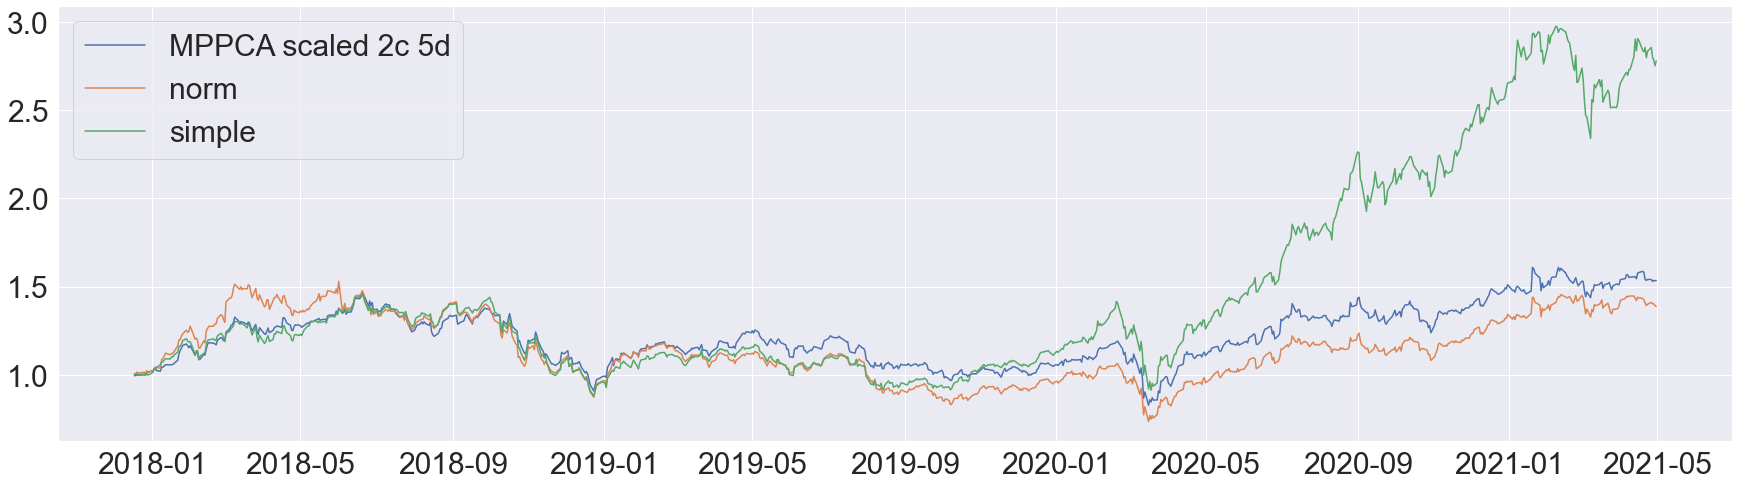

In [88]:
plt.figure(figsize=(30, 8))
plt.plot(ret.index, ret, label='MPPCA scaled 2c 5d')
plt.plot(ret2.index, ret2, label='norm')
plt.plot(ret3.index, ret3, label='simple')
plt.legend(loc='upper left');